In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = '_Mmin10'
geo_tag = '_bins10'
scalar_tag = '_n3'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1_Mmin10.yaml
../configs/scalar_TNG100-1_Mmin10_bins10_n3.yaml


In [4]:
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

# Load in objects; need no matter what feature type
sim_reader = SimulationReader(halo_params['sim']['base_dir'], halo_params['sim']['sim_name'], 
                              halo_params['sim']['sim_name_dark'], halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(halo_params['halo']['fn_dark_halo_arr'])
sim_reader.read_simulations() # TODO: do we need this step?

In [5]:
x_scalars, x_scalars_extra = utils.load_features('scalars', sim_reader, fn_scalar_config=fn_scalar_config)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
loading scalar features
loaded


In [6]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

In [7]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [12]:
np.min(log_m_200m+log_mass_shift), np.max(log_m_200m+log_mass_shift)

(0.1205514, 4.5631375)

(array([2.540e+02, 7.050e+02, 1.990e+03, 4.887e+03, 5.949e+03, 4.801e+03,
        3.630e+03, 2.633e+03, 1.876e+03, 1.442e+03, 1.055e+03, 7.640e+02,
        5.770e+02, 4.440e+02, 2.850e+02, 2.230e+02, 1.740e+02, 1.250e+02,
        1.110e+02, 5.200e+01, 6.200e+01, 3.600e+01, 1.700e+01, 1.700e+01,
        1.700e+01, 7.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 3.000e+00]),
 array([10.120551 , 10.268638 , 10.416723 , 10.56481  , 10.712896 ,
        10.860982 , 11.0090685, 11.157154 , 11.305241 , 11.453327 ,
        11.601413 , 11.749499 , 11.897586 , 12.045671 , 12.193758 ,
        12.341845 , 12.48993  , 12.638017 , 12.786102 , 12.934189 ,
        13.082275 , 13.230361 , 13.378448 , 13.526534 , 13.67462  ,
        13.822706 , 13.970792 , 14.118878 , 14.266965 , 14.4150505,
        14.563137 ], dtype=float32),
 <BarContainer object of 30 artists>)

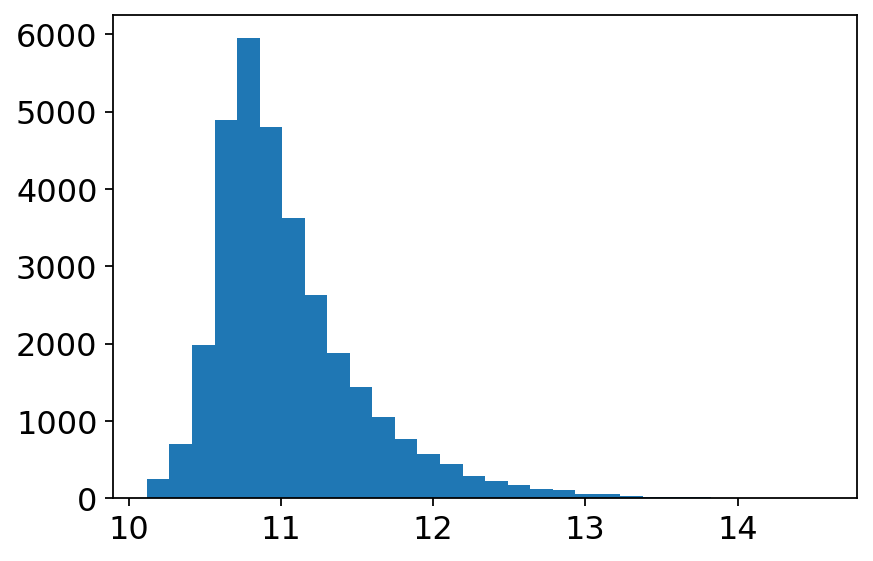

In [15]:
plt.hist(log_m_200m+log_mass_shift, bins=30)

# M stellar

In [8]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
#fit_tag = f'_{y_label_name}_nn_scalars_epochs1000_lr5e-05_hs128'
fit_tag = f'_{y_label_name}_hgboost_scalars_epochs300_lr0.1_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.npy'

In [9]:
y_pred = np.load(fn_pred)

In [10]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

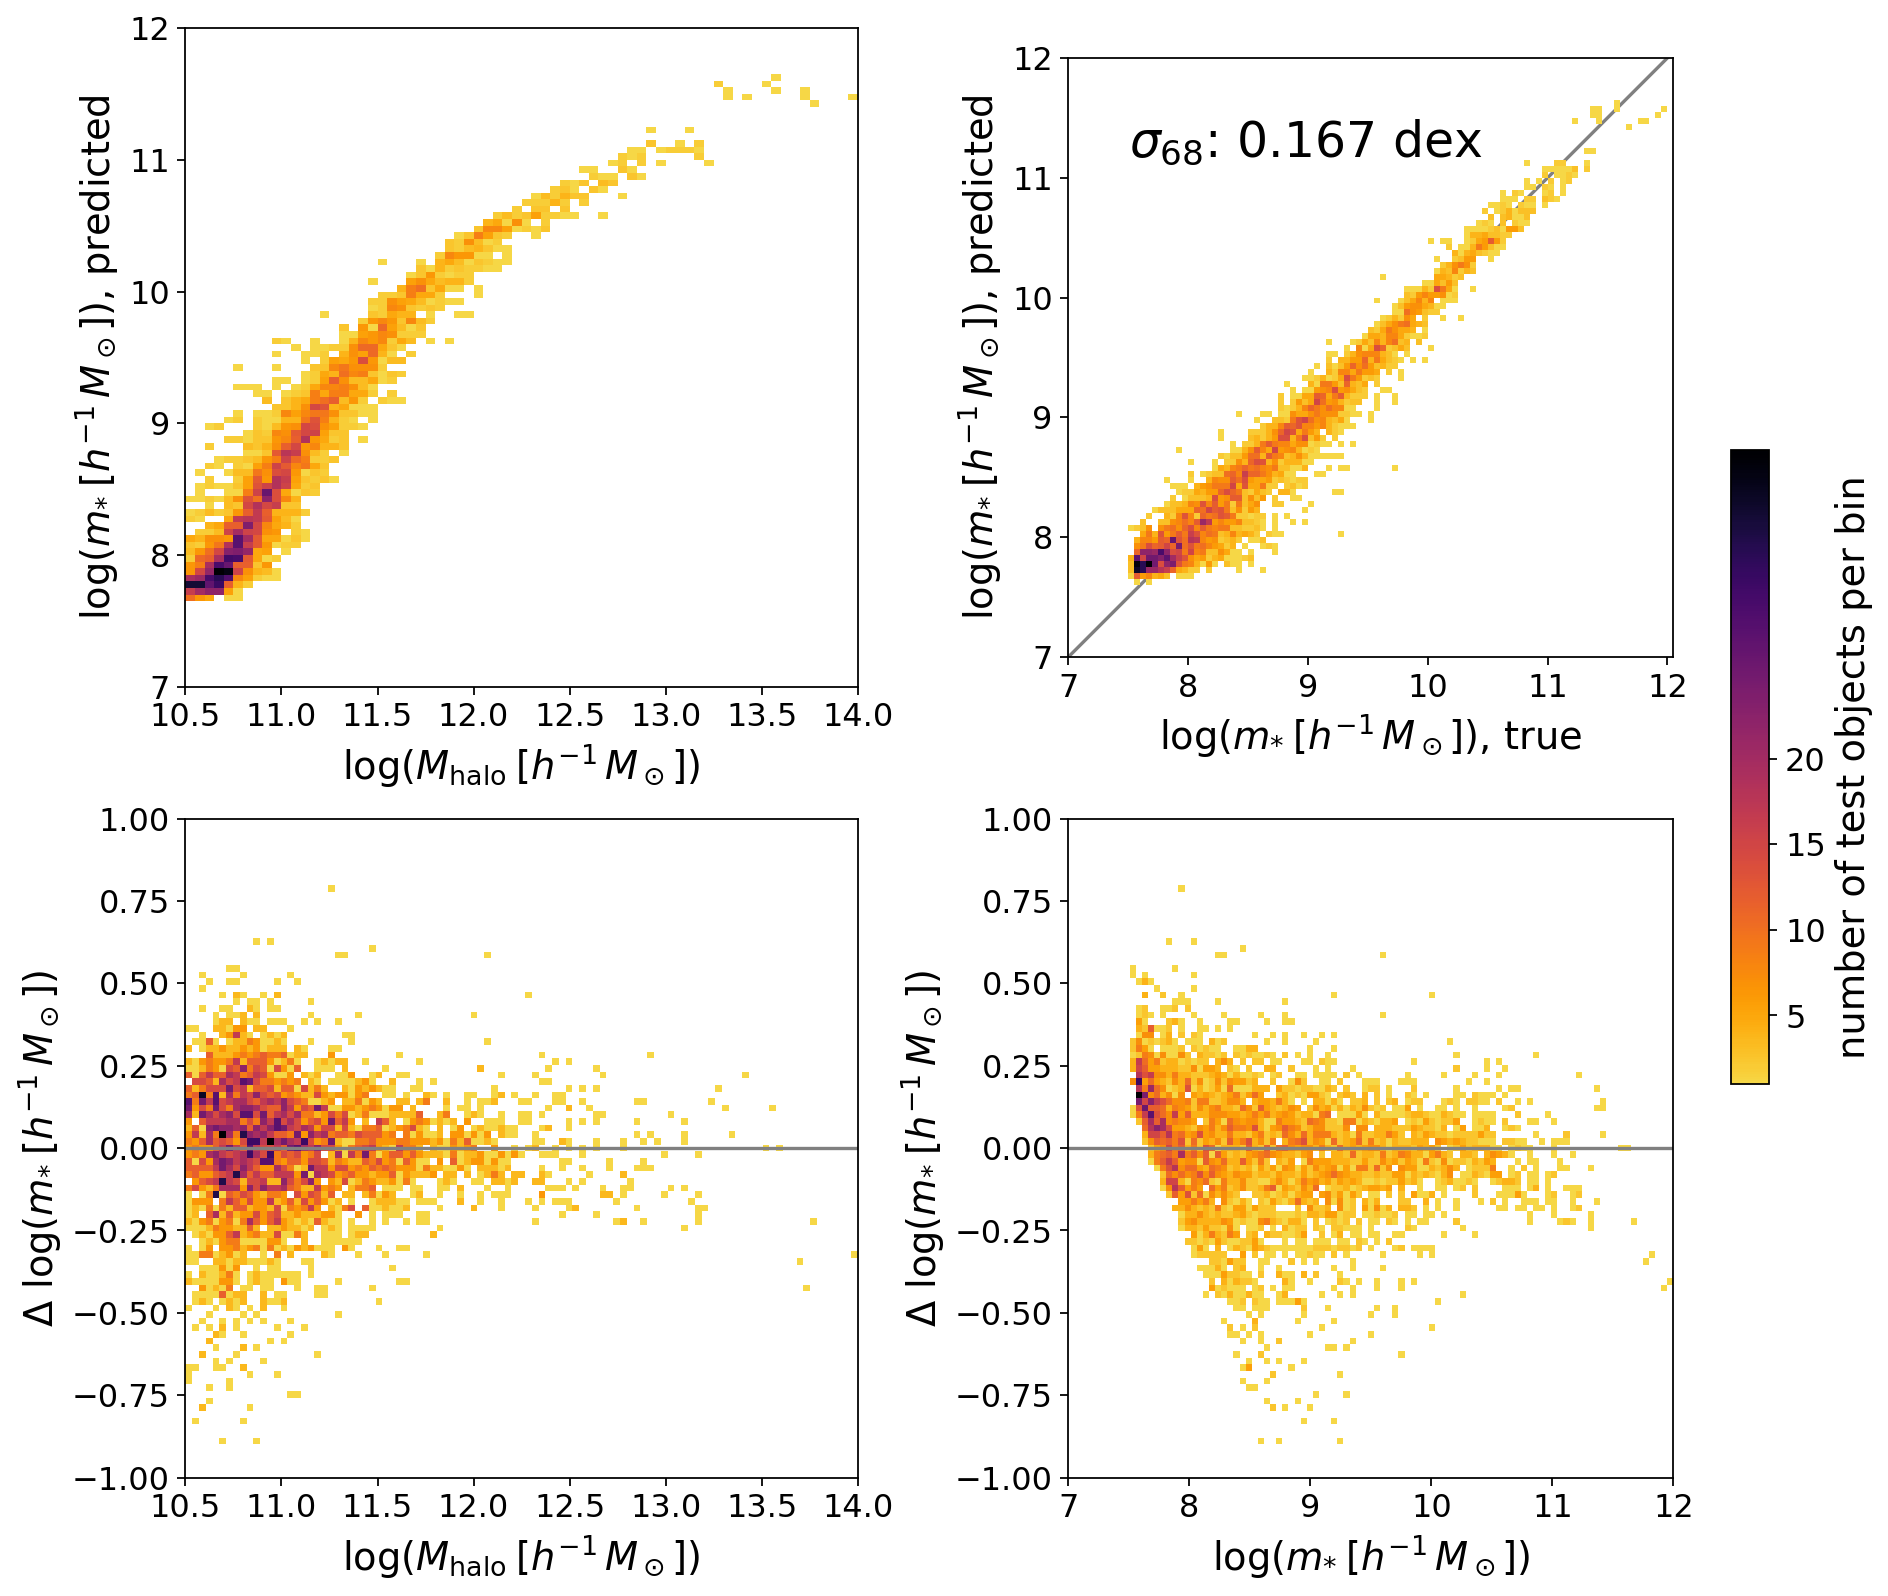

In [11]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test_mult, y_pred_mult, 
                              text_results=error_str)